In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection_y

# signal = ObjIter(Tree(fn) for fn in module.signal_list[-2])
signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(module.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
# ttbar = ObjIter([Tree(module.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

In [3]:
bkg = qcd 

100%|██████████| 1/1 [00:07<00:00,  7.43s/it]


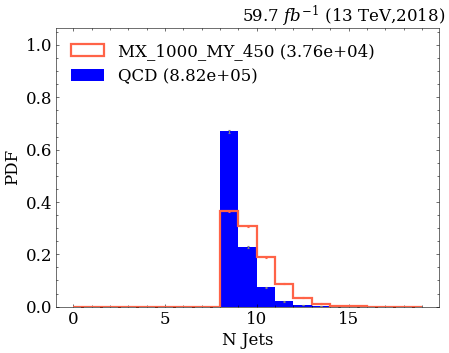

In [4]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['n_jet'],
  binlist=[np.arange(0,20)],
  efficiency=True,
  saveas='n_jet'
)

In [5]:
def btagmulti(t):
  btags = ak_stack([ t[f'{obj}_btag'] for obj in eightb.quarklist ])
  btagavg = ak.mean(btags,axis=-1)
  multi = { f'n_{label}_btag':ak.sum(btags>wp,axis=-1) for wp,label in zip(jet_btagWP, wplabels) }
  t.extend(btagavg=btagavg, **multi)
(signal+bkg).apply(btagmulti)

[None, None]

100%|██████████| 2/2 [00:06<00:00,  3.11s/it]


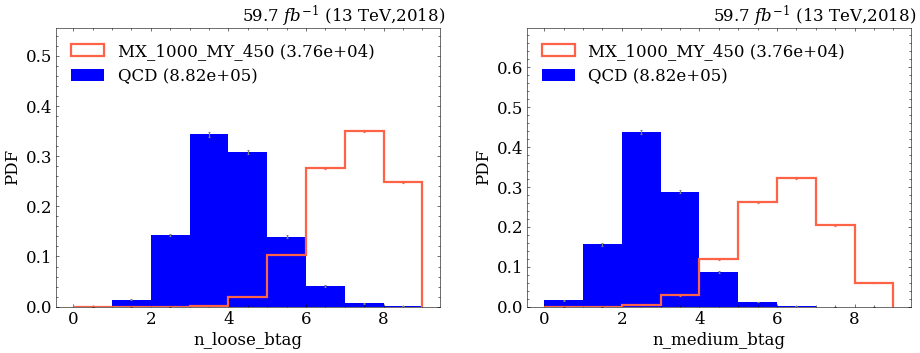

In [6]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['n_loose_btag','n_medium_btag'],
  binlist=[None, None, (0,0.7,30)],
  # dim=(-1,3),
  efficiency=True,
  saveas='selection_variables'
)

100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


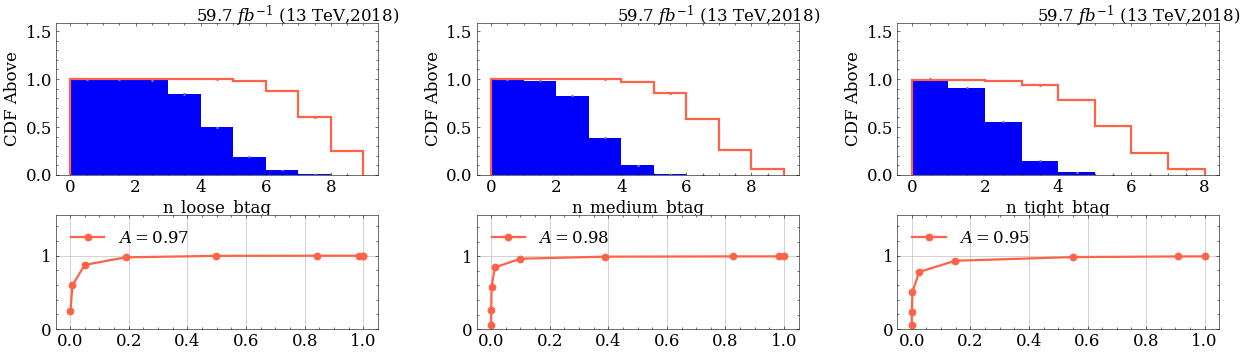

In [7]:

study.quick(
  signal+bkg, stacked=True,
  varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
  dim=(-1,3),
  efficiency=True,
  cumulative=-1,
  correlation=True,
)

100%|██████████| 2/2 [00:07<00:00,  3.55s/it]


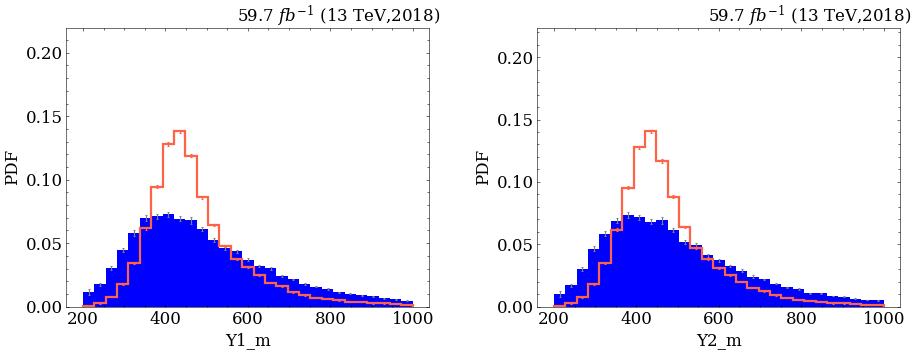

In [8]:
study.quick(
  signal+bkg, stacked=True,
  varlist=['Y1_m','Y2_m'],
  efficiency=True,
)

In [10]:
(signal+bkg).apply(lambda t: build_collection(t, 'H\dY\d','higgs',ptordered=True))

[None, None]

100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


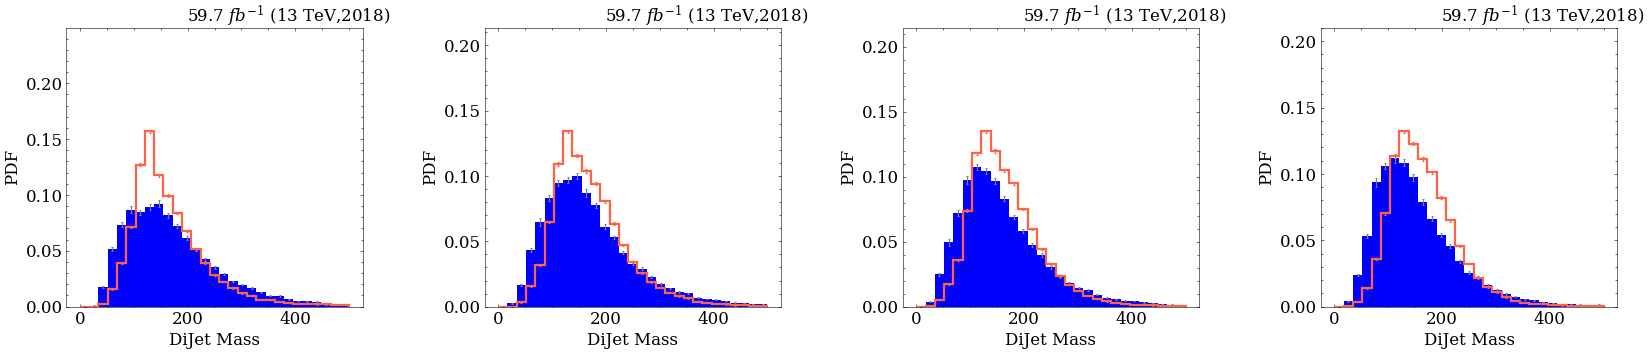

In [13]:
study.quick(
  signal+bkg, stacked=True,
  varlist=[f'higgs_m[:,{i}]' for i in range(4)],
  binlist=[(0,500,30)]*4,
  dim=(-1,4),
  efficiency=True,
)

100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


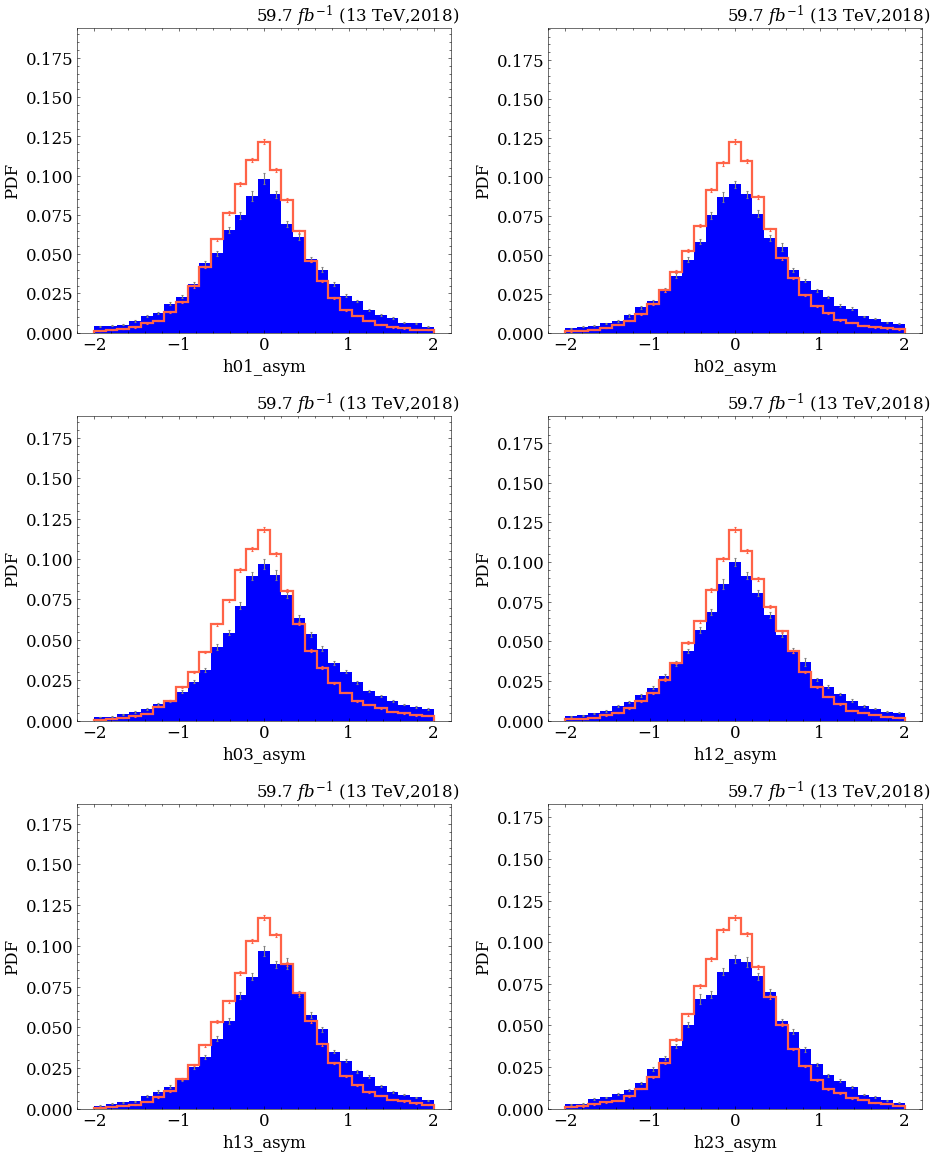

In [20]:
class hm_asym(ObjTransform):
  def str(self): return f'h{self.i}{self.j}_asym'
  def __call__(self, t):
    mi = t['higgs_m'][:,self.i]
    mj = t['higgs_m'][:,self.j]
    # return (mi-mj)/(mi+mj)
    return (mi-mj)/125.0

study.quick(
  signal+bkg, stacked=True,
  varlist=[hm_asym(i=i,j=j) for i in range(4) for j in range(i+1,4) ],
  binlist=[(-2,2,30)]*6,
  # dim=(-1,4),
  efficiency=True,
)

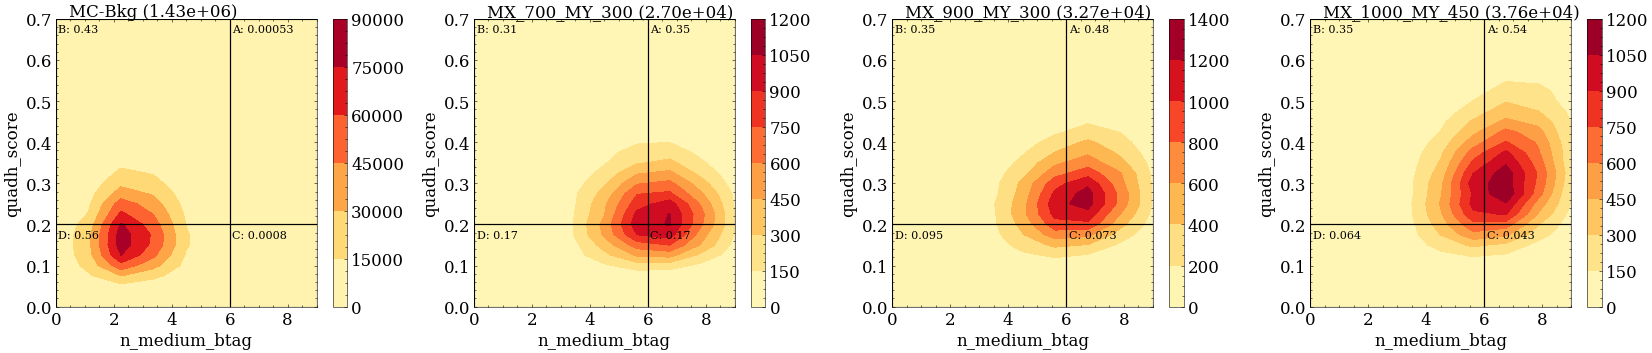

In [27]:
# fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig, axs = study.get_figax(4, dim=(-1,4))

v1 = 'n_medium_btag'
v2 = 'quadh_score'

region = dict(x_r=(0,6,9), y_r=(0,0.2,0.7))

study.quick2d_region(
  bkg, label=['MC-Bkg'],
  varlist=[v1, v2],
  binlist=[None, (0,0.7,30)],
  contour=True,
  figax=(fig,axs[0]),
  exe=draw_abcd(**region)
)

study.quick2d(
  signal,
  varlist=[v1, v2],
  binlist=[None, (0,0.7,30)],
  figax=(fig,axs[1:]),
  dim=(-1,3),
  contour=True,
  exe=draw_abcd(**region)
)

fig.tight_layout()

study.save_fig(fig, '', 'selection_variables_2d')

In [28]:
def get_abcd_masks(v1_r, v2_r):
  v1_sr = lambda t : (t[v1] >= v1_r[1]) & (t[v1] < v1_r[2])
  v1_cr = lambda t : (t[v1] >= v1_r[0]) & (t[v1] < v1_r[1])

  v2_sr = lambda t : (t[v2] >= v2_r[1]) & (t[v2] < v2_r[2])
  v2_cr = lambda t : (t[v2] >= v2_r[0]) & (t[v2] < v2_r[1])

  r_a = lambda t : v1_sr(t) & v2_sr(t)
  r_b = lambda t : v1_cr(t) & v2_sr(t)

  r_c = lambda t : v1_sr(t) & v2_cr(t)
  r_d = lambda t : v1_cr(t) & v2_cr(t)
  return r_a, r_b, r_c, r_d

def get_region_scale(r):
  t = bkg.apply(lambda t:t.scale).apply(np.sum).npy.sum()
  n = bkg.apply(lambda t:t.scale[r(t)]).apply(np.sum).npy.sum()
  e = np.sqrt(bkg.apply(lambda t:(t.scale[r(t)])**2).apply(np.sum).npy.sum())
  return n/t,e/t


def get_abcd_scale(r_a, r_b, r_c, r_d):
  n_d, e_d = get_region_scale(r_d)
  n_c, e_c = get_region_scale(r_c)
  n_b, e_b = get_region_scale(r_b)
  n_a, e_a = get_region_scale(r_a)

  print(n_a, n_b, n_c, n_d)
  k_factor = n_c/n_d
  e_factor = k_factor*np.sqrt( (e_c/n_c)**2 + (e_d/n_d)**2 )
  k_target = n_a/n_b
  e_target = k_target*np.sqrt( (e_a/n_a)**2 + (e_b/n_b)**2 )

  n_model = k_factor*n_b
  e_model = n_model*np.sqrt( (e_factor/k_factor)**2 )

  return (k_target, e_target), (k_factor, e_factor), (n_model, e_model)

In [39]:
abcd_regions = {
  'nominal':                    [(0,5,9),(0,0.2 ,0.7)],
  'validation/btag_hi':         [(3,5,9),(0,0.2 ,0.7)],
  'validation/btag_lo':         [(0,3,5),(0,0.2 ,0.7)],
  'validation/score_lo':        [(0,5,9),(0,0.15,0.2)],
  'validation/btag_hi_score_lo':[(3,5,9),(0,0.15,0.2)],
  'validation/btag_lo_score_lo':[(0,3,5),(0,0.15,0.2)]
}

In [40]:
# abcd_regions = {
  # 'nominal':                    [(0,6,9),(0,0.2 ,0.7)],
  # 'validation/btag_hi':         [(3,5,9),(0,0.2 ,0.7)],
  # 'validation/btag_lo':         [(0,3,5),(0,0.2 ,0.7)],
  # 'validation/score_lo':        [(0,5,9),(0,0.15,0.2)],
  # 'validation/btag_hi_score_lo':[(3,5,9),(0,0.15,0.2)],
  # 'validation/btag_lo_score_lo':[(0,3,5),(0,0.15,0.2)]
# }

In [41]:
region = 'nominal'
v1_r, v2_r = abcd_regions[region]
r_a, r_b, r_c, r_d = get_abcd_masks(v1_r, v2_r)
(k_target, e_target), (k_factor, e_factor), (n_model, e_model) = get_abcd_scale(r_a, r_b, r_c, r_d)

(k_factor, 100*e_factor/k_factor)

0.005954218822260609 0.4292978559109439 0.006817598113188341 0.5579273728229754


(0.012219508210706654, 4.978759899905877)

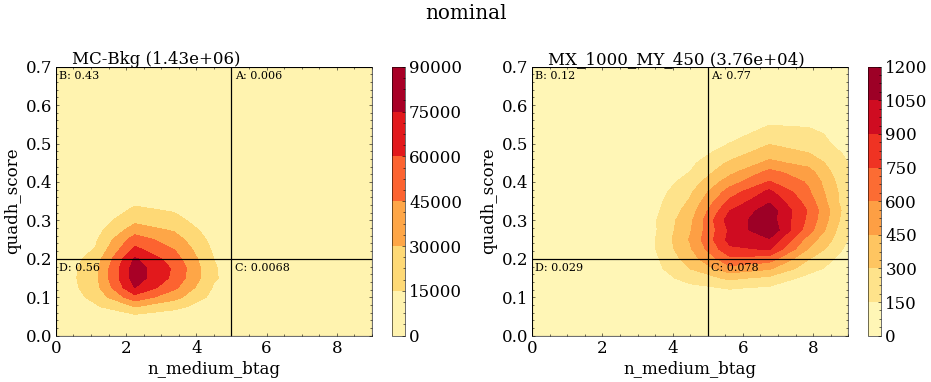

In [42]:
# fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig, axs = study.get_figax(2)

study.quick2d_region(
  bkg, label=['MC-Bkg'],
  varlist=[v1, v2],
  binlist=[None, (0,0.7,30)],
  contour=True,
  figax=(fig,axs[0]),
  dim=(1,1),
  exe=draw_abcd(x_r=v1_r, y_r=v2_r)
)

study.quick2d(
  signal[[-1]],
  varlist=[v1, v2],
  binlist=[None, (0,0.7,30)],
  figax=(fig,axs[1]),
  dim=(1,1),
  contour=True,
  exe=draw_abcd(x_r=v1_r, y_r=v2_r),
  title=region,
)

fig.tight_layout()

study.save_fig(fig, '', 'selection_variables_2d')

In [43]:
(n_model, e_model/n_model)

(0.005245808675142541, 0.04978759899905877)

100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


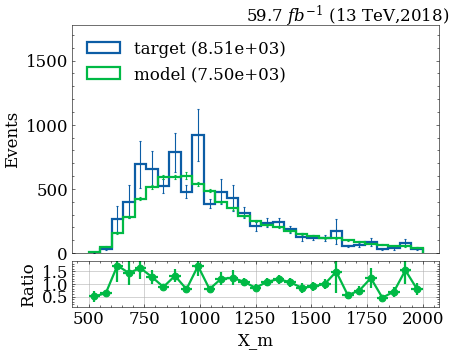

In [31]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',

  ratio=True,

  saveas='model_X_m'
)

In [32]:
ratio = k_target/k_factor
# error = ratio*np.sqrt( (e_target/k_target)**2 + (e_factor/k_factor)**2 )
error = ratio*np.sqrt( (e_factor/k_factor)**2 )

ratio, error/ratio

(1.1350430774333986, 0.04978759899905877)

In [33]:
x = np.linspace(0, 1.5, 1000)
y = f_stats.kstwobign.sf(x)

In [34]:
from scipy import optimize

def f(x):
  return np.abs(f_stats.kstwobign.sf(x) - 0.05)

optimize.fmin(f, 1)

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 14
         Function evaluations: 28


array([1.35810547])

100%|██████████| 1/1 [00:05<00:00,  5.51s/it]


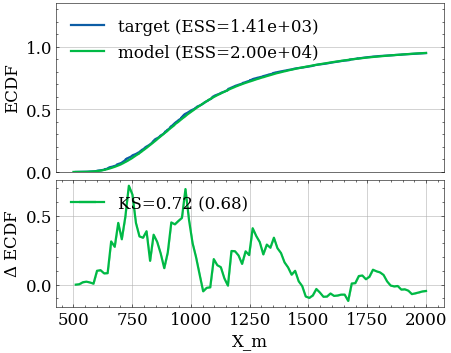

In [24]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'ESS={np.sum(h.weights)**2/np.sum(h.weights**2):0.2e}',

  histo=False,
  empirical=True,
  e_legend=True,
  e_ylim=(0,1.35),

  e_difference=True,
  e_d_size='75%',
  e_d_ylabel='$\Delta$ ECDF',
  e_d_legend_loc='upper left',

  saveas='model_X_m_kstest'
)

100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


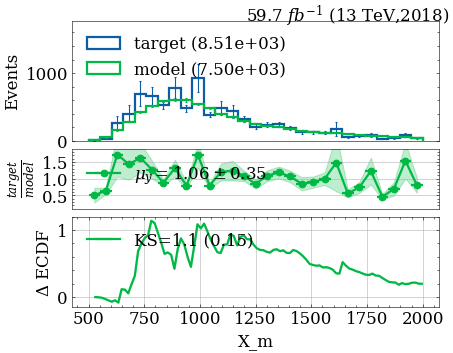

In [35]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',
  legend_loc='upper left',

  ratio=True,
  r_size='50%',
  r_fill_error=True,
  r_ylabel=r'$\frac{target}{model}$',
  r_label_stat='y_mean_std',
  r_legend=True,
  r_legend_loc='upper left',

  empirical=True,
  # e_ylim=(-0.15,1.15),
  e_show=False,

  e_difference=True,
  e_d_size='75%',
  e_d_ylabel='$\Delta$ ECDF',
  e_d_legend_loc='upper left',

  saveas='model_X_m_full'
)

100%|██████████| 1/1 [00:18<00:00, 18.77s/it]


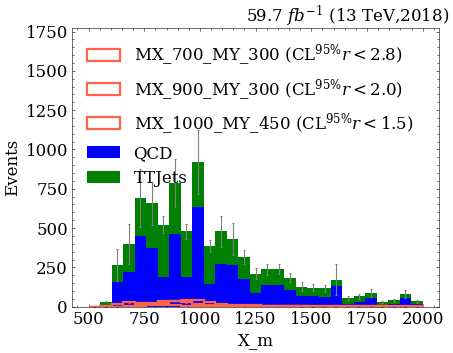

In [38]:
study.quick(
  signal + bkg, 
  varlist=['X_m'], stacked=True, legend=True,
  masks=[r_a]*len(signal) + [r_a]*len(bkg),
  scale=[1e-2]*len(signal) + [1]*len(bkg),
  limits=True,
)

100%|██████████| 1/1 [00:24<00:00, 24.59s/it]


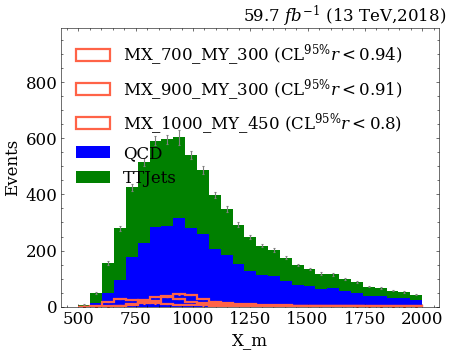

In [37]:
study.quick(
  signal + bkg, 
  varlist=['X_m'], stacked=True, legend=True,
  masks=[r_a]*len(signal) + [r_b]*len(bkg),
  scale=[1e-2]*len(signal) + [k_factor]*len(bkg),
  limits=True,
)